In [1]:
from face_detector import YoloDetector
import numpy as np
from PIL import Image, ImageDraw
import re
import yt_dlp
from imutils import paths, build_montages
import face_recognition
import pickle
from sklearn.cluster import DBSCAN
from pyPiper import Node, Pipeline
from tqdm import tqdm
import cv2
import os
from imutils import paths

In [2]:
class ResizeUtils:
    # Given a target height, adjust the image by calculating the width and resize
    def rescale_by_height(self, image, target_height, method=cv2.INTER_LANCZOS4):
        """Rescale `image` to `target_height` (preserving aspect ratio)."""
        w = int(round(target_height * image.shape[1] / image.shape[0]))
        return cv2.resize(image, (w, target_height), interpolation=method)

    # Given a target width, adjust the image by calculating the height and resize
    def rescale_by_width(self, image, target_width, method=cv2.INTER_LANCZOS4):
        """Rescale `image` to `target_width` (preserving aspect ratio)."""
        h = int(round(target_width * image.shape[0] / image.shape[1]))
        return cv2.resize(image, (target_width, h), interpolation=method)

def auto_resize(frame):
    resizeUtils = ResizeUtils()

    height, width, _ = frame.shape

    if height > 500:
        frame = resizeUtils.rescale_by_height(frame, 500)
        auto_resize(frame)
    
    if width > 700:
        frame = resizeUtils.rescale_by_width(frame, 700)
        auto_resize(frame)
    
    return frame

class VideoProcessor:
    def __init__(self, url):
        resizeUtils = ResizeUtils()
        self.video_id = self.get_videoid(url)
        
        self.video_dir = os.path.join("videos", self.video_id)
        os.makedirs(self.video_dir,exist_ok=True)
        
        self.video_path = os.path.join(self.video_dir, self.video_id + ".mp4")
        self.encodings_pkl_path = os.path.join(self.video_dir,"encodings.pkl")
        
        self.frames_dir = os.path.join(self.video_dir,"frames")
        os.makedirs(self.frames_dir,exist_ok=True)
        
        self.encodings_dir = os.path.join(self.video_dir, "encodings")
        os.makedirs(self.encodings_dir,exist_ok=True)
        
        self.download_video()

    def download_video(self):
        if os.path.exists(self.video_path):
            print("file exists")
            return
        ydl_opts = {
            "format": "bestvideo[height<=360][ext=mp4]+bestaudio[ext=m4a]/best[height<=360][ext=mp4]",
            "outtmpl": self.video_path,
        }
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([f"https://youtube.com/watch?v={self.video_id}"])
            
    def get_videoid(self, url):
        re_match = re.match(
            "(?:https?:\/\/)?(?:www\.)?(?:youtube\.com\/(?:[^\/\n\s]+\/\S+\/|(?:v|e(?:mbed)?)\/|\S*?[?&]v=)|youtu\.be\/)([a-zA-Z0-9_-]{11})",
            url,
        )
        return re_match.group(1)
    
    def extract_frames(self, save_freq=60):    
        print(self.frames_dir)
        os.makedirs(self.frames_dir, exist_ok=True)
        
        cap = cv2.VideoCapture(self.video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        # Loop through each frame in the video
        frame_count = 0
        while cap.isOpened():
            # Read the frame
            ret, frame = cap.read()
            if not ret: break
            
            frame = auto_resize(frame)
            # Process Frame

            if frame_count % int(fps) == 0:
                filename = f"frame_{frame_count}.jpg"
                cv2.imwrite(os.path.join(self.frames_dir, filename), frame)
                print("saving",filename)
            frame_count += 1
        print("DONE")

    def extract_encodings(self):
        image_paths = list(paths.list_images(self.frames_dir))
        data = []

        for (i, image_path) in enumerate(image_paths):
            # load the input image and convert it from RGB (OpenCV ordering)
            # to dlib ordering (RGB)
            # print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)))
            print('processing image',i)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            boxes = face_recognition.face_locations(image, model="cnn")
            encodings = face_recognition.face_encodings(image, boxes) 
            d = [{"image_path": image_path, "loc": box, "encoding": enc}
        		for (box, enc) in zip(boxes, encodings)]
            # Write encodings to file
            with open(os.path.join(self.encodings_dir, 'encodings_' + str(i) + '.pickle'), 'wb') as f:
                f.write(pickle.dumps(encodings))
            data.extend(d)
    
        print("[INFO] serializing encodings...")
        f = open(self.encodings_pkl_path, "wb")
        f.write(pickle.dumps(data))
        f.close()
        print("done")

    def cluster_images(self):
        # load the data
        NumberOfParallelJobs = -1
        
        # load the serialized face encodings + bounding box locations from
        # disk, then extract the set of encodings to so we can cluster on
        # them
        print("[INFO] Loading encodings")
        data = pickle.loads(open(self.encodings_pkl_path, "rb").read())
        data = np.array(data)
        
        encodings = [d["encoding"] for d in data]
        
        # cluster the embeddings
        print("[INFO] Clustering")
        clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=NumberOfParallelJobs)
        clt.fit(encodings)
        print("DONE")
        
        # determine the total number of unique faces found in the dataset
        labels = clt.labels_
        print(labels)
        label_ids = np.unique(labels)
        numUniqueFaces = len(np.where(label_ids > -1)[0])
        print("[INFO] # unique faces: {}".format(numUniqueFaces))
        
        for label in range(numUniqueFaces):
            ids = np.where(labels == label)[0]
            print("Person", label, "photos", len(ids))
            for id in ids[:3]:
                image = cv2.imread(data[id]["image_path"])
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                (o_top, o_right, o_bottom, o_left) = data[id]["loc"]
                
                height, width, channel = image.shape
                
                widthMargin = 10
                heightMargin = 20
                
                top = o_top - heightMargin
                if top < 0:
                    top = 0
                
                bottom = o_bottom + heightMargin
                if bottom > height:
                    bottom = height
                
                left = o_left - widthMargin
                if left < 0:
                    left = 0
                
                right = o_right + widthMargin
                if right > width:
                    right = width
                
                portrait = image[top:bottom, left:right]
                
                resizeUtils = ResizeUtils()
                portrait = resizeUtils.rescale_by_width(portrait, 200)
                
                display(Image.fromarray(portrait))
        return clt.labels_

!rm -rf videos/1hfcZll-qxY
vp = VideoProcessor("https://www.youtube.com/watch?v=kloNp7AAz0U")
vp.extract_frames()
vp.extract_encodings()
vp.cluster_images()


file exists
videos/kloNp7AAz0U/frames
saving frame_0.jpg
saving frame_29.jpg
saving frame_58.jpg
saving frame_87.jpg
saving frame_116.jpg
saving frame_145.jpg
saving frame_174.jpg
saving frame_203.jpg
saving frame_232.jpg
saving frame_261.jpg
saving frame_290.jpg
saving frame_319.jpg
saving frame_348.jpg
saving frame_377.jpg
saving frame_406.jpg
saving frame_435.jpg
saving frame_464.jpg
saving frame_493.jpg
saving frame_522.jpg
saving frame_551.jpg
saving frame_580.jpg
saving frame_609.jpg
saving frame_638.jpg
saving frame_667.jpg
saving frame_696.jpg
saving frame_725.jpg
saving frame_754.jpg
saving frame_783.jpg
saving frame_812.jpg
saving frame_841.jpg
saving frame_870.jpg
saving frame_899.jpg
saving frame_928.jpg
saving frame_957.jpg
saving frame_986.jpg
saving frame_1015.jpg
saving frame_1044.jpg
saving frame_1073.jpg
saving frame_1102.jpg
saving frame_1131.jpg
saving frame_1160.jpg
saving frame_1189.jpg
saving frame_1218.jpg
saving frame_1247.jpg
saving frame_1276.jpg
saving frame

KeyboardInterrupt: 

# Face Recognition

In [3]:
from imutils import paths, build_montages
import face_recognition
import argparse
import pickle
import cv2
import os
from sklearn.cluster import DBSCAN
import numpy as np
import pickle
import time
import shutil

## Extract Frames

In [53]:
video_path = "video.mp4"
frames_dir = "frames"
encodings_dir = "encodings"
encodings_path = "encodings.pickle"

def mkdir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
mkdir(frames_dir)
mkdir(encodings_dir)

cap = cv2.VideoCapture(video_path)
_, frame = cap.read()

fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)


current_frame = 1
fps_counter = 0
frame_write_count = 1
while current_frame < total_frames:
    success, frame = cap.read()
    if not success:
        break
    
    if fps_counter > fps:
        fps_counter = 0

        frame = auto_resize(frame)

        filename = "frame_" + str(frame_write_count) + ".jpg"
        cv2.imwrite(os.path.join(frames_dir, filename), frame)

        frame_write_count += 1
    if current_frame % 50 == 0:
        print('got frame',current_frame)
    fps_counter += 1
    current_frame += 1

got frame 50
got frame 100
got frame 150
got frame 200
got frame 250
got frame 300
got frame 350
got frame 400
got frame 450
got frame 500
got frame 550
got frame 600
got frame 650
got frame 700
got frame 750
got frame 800
got frame 850
got frame 900
got frame 950
got frame 1000
got frame 1050
got frame 1100
got frame 1150
got frame 1200
got frame 1250
got frame 1300
got frame 1350
got frame 1400
got frame 1450
got frame 1500
got frame 1550
got frame 1600
got frame 1650
got frame 1700
got frame 1750
got frame 1800
got frame 1850


## Extract Encodings
something here is going wrong!

In [104]:
for i, img_path in enumerate(paths.list_images(frames_dir)):
    image = cv2.imread(img_path)
    print(img_path)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = face_recognition.face_locations(rgb, model="cnn")
    fr_encodings = face_recognition.face_encodings(rgb, boxes)
    print(len(boxes),len(fr_encodings))
    d = [{"imagePath": img_path, "loc": box, "encoding": enc} 
            for (box, enc) in zip(boxes, fr_encodings)]
    # Save pkl
    with open(os.path.join(encodings_dir, 
                        'encodings_' + str(i) + '.pickle'), 'wb') as f:
        f.write(pickle.dumps(d))

frames/frame_35.jpg
1 1
frames/frame_55.jpg
1 1
frames/frame_15.jpg
1 1
frames/frame_16.jpg
1 1
frames/frame_7.jpg
1 1
frames/frame_53.jpg
1 1
frames/frame_32.jpg
1 1
frames/frame_10.jpg
1 1
frames/frame_45.jpg
1 1
frames/frame_36.jpg
1 1
frames/frame_18.jpg
2 2
frames/frame_47.jpg
1 1
frames/frame_21.jpg
1 1
frames/frame_60.jpg
0 0
frames/frame_43.jpg
2 2
frames/frame_40.jpg
1 1
frames/frame_46.jpg
1 1
frames/frame_38.jpg
1 1
frames/frame_61.jpg
0 0
frames/frame_39.jpg
1 1
frames/frame_19.jpg
1 1
frames/frame_20.jpg
1 1
frames/frame_13.jpg
1 1
frames/frame_41.jpg
1 1
frames/frame_8.jpg
1 1
frames/frame_25.jpg
2 2
frames/frame_6.jpg
1 1
frames/frame_56.jpg
1 1
frames/frame_51.jpg
1 1
frames/frame_9.jpg
1 1
frames/frame_14.jpg
1 1
frames/frame_59.jpg
0 0
frames/frame_12.jpg
1 1
frames/frame_54.jpg
1 1
frames/frame_11.jpg
2 2
frames/frame_22.jpg
1 1
frames/frame_33.jpg
1 1
frames/frame_48.jpg
1 1
frames/frame_28.jpg
1 1
frames/frame_30.jpg
1 1
frames/frame_3.jpg
1 1
frames/frame_50.jpg
1

## Generate Big Pickle

In [124]:
encodings_dir = "/home/lucaspy/FaceRecognitionPipeline_GeeksForGeeks/Encodings"
encodings_dir = "encodings"

datastore = []
pickle_paths = []
for item in os.listdir(encodings_dir):
    _, fileExt = os.path.splitext(item)
    if fileExt == '.pickle':
        pickle_paths.append(os.path.join(encodings_dir, item))

for picklePath in pickle_paths:
    with open(picklePath, "rb") as f:
        data = pickle.loads(f.read())
        datastore.extend(data)

print(datastore[1]['loc'],datastore[0]['imagePath'])
with open(encodings_path, 'wb') as f:
    f.write(pickle.dumps(datastore))

# (74, 439, 215, 297) frames/frame_36.jpg

(55, 473, 259, 269) frames/frame_36.jpg


In [98]:
# load the data
encodings_path = "/home/lucaspy/yoloface/encodings.pickle"
data = pickle.loads(open(encodings_path, "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
clt = DBSCAN(eps=0.5, metric="euclidean", n_jobs=-1)
clt.fit(encodings)
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

[INFO] # unique faces: 6


In [34]:
# gen images
data = pickle.loads(open(encodings_path, "rb").read())
data = np.array(data)
for labelID in labelIDs:
    print("[INFO] faces for face ID: {}".format(labelID))
    image_path_ids = np.where(clt.labels_ == labelID)[0]
    for i in image_path_ids:
        display(Image.open(imagePaths[i]))
        

[INFO] faces for face ID: -1


NameError: name 'imagePaths' is not defined

# Face Extract Test

In [27]:
def resize_image(image, new_width):
    original_width, original_height = image.size
    aspect_ratio = original_height / original_width
    new_height = int(new_width * aspect_ratio)
    return image.resize((new_width,new_height))

cpu
/home/lucaspy/yoloface/weights/yolov5n_state_dict.pt
(3800, 1359)


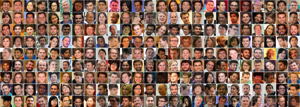

Extract Faces
227 Faces


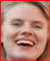

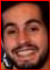

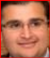

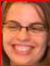

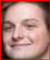

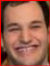

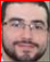

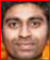

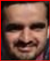

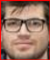

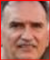

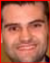

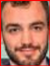

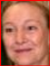

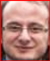

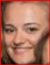

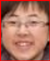

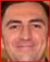

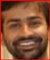

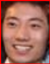

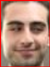

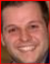

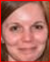

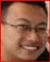

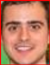

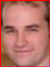

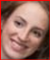

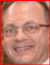

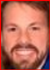

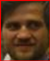

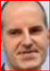

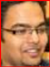

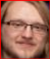

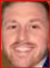

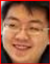

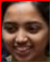

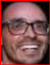

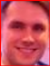

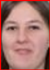

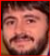

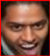

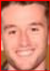

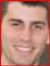

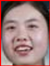

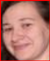

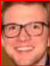

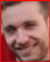

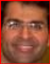

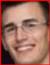

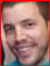

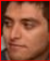

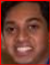

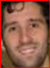

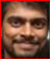

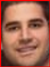

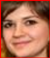

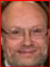

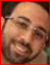

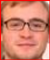

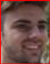

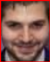

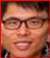

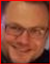

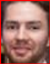

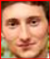

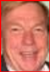

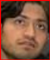

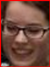

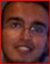

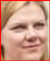

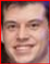

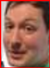

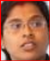

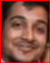

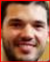

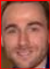

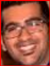

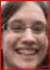

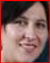

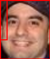

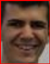

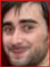

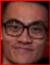

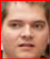

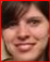

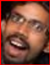

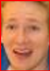

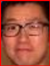

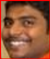

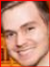

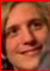

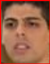

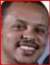

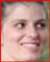

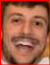

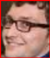

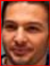

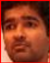

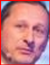

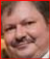

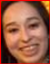

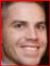

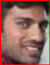

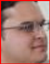

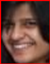

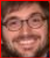

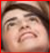

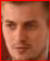

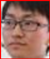

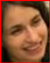

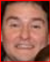

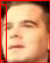

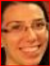

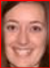

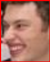

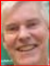

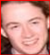

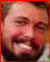

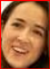

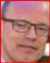

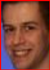

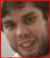

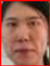

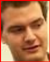

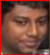

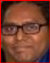

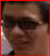

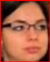

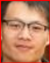

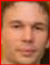

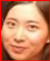

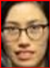

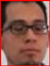

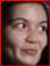

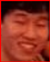

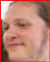

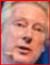

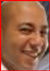

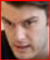

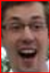

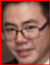

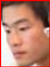

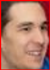

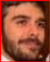

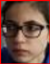

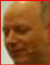

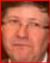

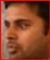

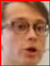

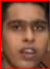

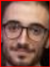

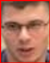

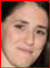

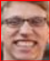

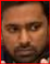

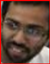

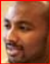

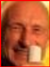

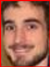

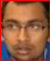

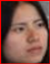

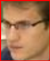

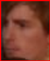

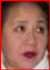

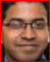

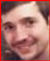

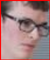

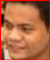

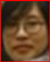

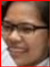

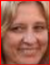

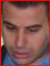

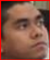

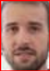

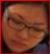

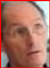

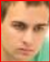

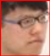

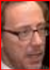

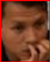

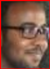

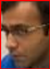

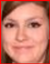

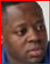

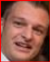

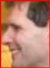

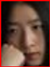

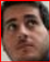

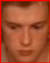

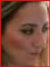

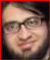

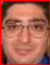

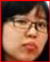

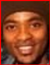

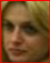

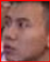

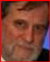

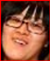

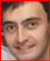

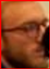

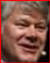

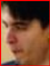

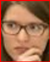

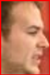

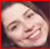

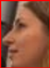

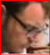

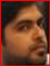

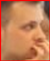

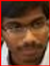

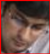

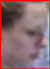

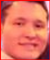

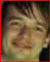

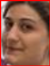

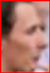

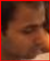

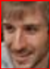

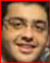

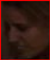

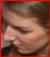

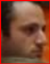

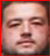

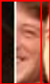

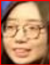

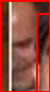

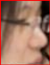

NameError: name 'os' is not defined

In [3]:
model = YoloDetector(target_size=800, device="cpu", min_face=90)

img = Image.open("many_faces.jpg")
img = resize_image(img, 3800)
print(img.size)
display(resize_image(img, 300))

# predict
bboxes, points = model.predict(np.array(img))

# Place bounding boxes
draw = ImageDraw.Draw(img)
for box in bboxes[0]:
    draw.rectangle(box, outline='red', width=2)

# Extract faces
print("Extract Faces")
faces = []
for box in bboxes[0]:
    face = resize_image(img.crop(box),50)
    faces.append(face)
    
print(len(faces),"Faces")
for face in faces:
    display(face)

for i in range(len(faces)):
    faces[i].save(os.path.join("yt",f"{i}.jpg"))